# Data Visualization and dimensionality reduction

## Load MNIST

In [ ]:
# Load MNIST train data (60000) and test data (10000)
import numpy as np
import matplotlib.pyplot as plt 

filename = "/Users/wenxinxu/Desktop/SDS565/data/MNIST/"

## training data and labels
# load training image data
f=open(filename + 'train-images-idx3-ubyte','rb')
gimage=f.read()
f.close()

# load training labels
f=open(filename + 'train-labels-idx1-ubyte','rb')
g=f.read()
f.close()

n_train = 60000
n_test = 10000
dimH, dimW = 28, 28

# create training matrix 60000 x 28 x 28
train=np.array(bytearray(gimage[16:])).reshape(n_train,dimH,dimW)
# train.shape = (n_train,dimH,dimW)
train_labels=np.array(bytearray(g[8:]))

## load image data
f=open(filename + 't10k-images-idx3-ubyte','rb')
gimage=f.read()
f.close()

## load labels
f=open(filename + 't10k-labels-idx1-ubyte','rb')
g=f.read()
f.close()

# create test matrix 10000 x 28 x 28
test=np.array(bytearray(gimage[16:])).reshape(n_test,dimH,dimW)
# test.shape=(n_test,dimH,dimW)
test_labels=np.array(bytearray(g[8:]))

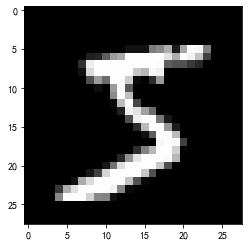

In [ ]:
# plot first training data
plt.imshow(train[0,:,:],cmap='gray')

## make training set and test set

In [ ]:
# select images of digits 0 and 8 from data to do binary classification
# make label True (digit 8), False (digit 0)
X08 = train[np.logical_or(train_labels==0,train_labels==8)]
y08 = train_labels[np.logical_or(train_labels==0,train_labels==8)] == 8
X08.shape = (X08.shape[0], X08.shape[1]*X08.shape[2])   # reshape training data to (60000, 28*28)

X08test =  test[np.logical_or(test_labels==0,test_labels==8)]
y08test = test_labels[np.logical_or(test_labels==0,test_labels==8)] ==8
X08test.shape = (X08test.shape[0], X08test.shape[1]*X08test.shape[2])   # reshape test data to (10000, 28*28)

In [ ]:
X08.shape

(11774, 784)

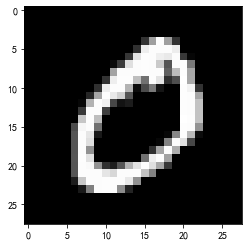

In [ ]:
# plot first training data 
plt.imshow(X08[0].reshape(28,28),cmap='gray')

## solve SVD

speed of solving SVD

- full matrix of X: 10s

- partial matrix of X: 4s

- full matrix of covaraince of X: 0.5s

- top k singular values of X: 0.1s

- Singular value decomposition of data matrix X

$$
X = USV^T
$$

- Eigendecomposition of covariance matrix $\Sigma = \frac{1}{n}XX^T$ of X 
$$
\Sigma = U'DU'^T
$$


`np.linalg.svd(X, full_matrices=False)`

singular value decomposition of a matrix X m*n takes time

to save time, can only solve `k = min(M, N)` singular values of X


`full_matrices` : bool, optional
    
- If `True` (default), `u` and `vh` have the shapes `(..., M, M)` and `(..., N, N)`, respectively.  
    
- If `False`, the shapes are `(..., M, k)` and `(..., k, N)`, respectively, 

`scipy.sparse.linalg.svd(X, k=)` to specify `k`

In [ ]:
from scipy.sparse import linalg
import numpy as np 

# data: take transpose and convert to float to work for PCA. shape (p, n), 784 singular values
X = X08.T*1.
mu = np.mean(X, axis=1) # (784,)
X = X-mu[:,None]    # normalize X by substract mean of column from column

# SVD of X
u,s,vt = np.linalg.svd(X, full_matrices=True)  # solve 784 singular values of X
unotfull,snotfull,vtnotfull = np.linalg.svd(X, full_matrices=False)  # faster
uk,sk,vtk = linalg.svds(X, k=2)

# ED of covariance of X
sigma = np.cov(X)  # X@X.T/X.shape[1]   covariance matrix of X
u1, s1, vt1 = np.linalg.svd(sigma) # even faster

print("Full matrix SVD: ", u.shape, s.shape, vt.shape )
print("Partial matrix SVD: ", unotfull.shape, snotfull.shape, vtnotfull.shape)
print("Top k SVD: ", uk.shape, sk.shape, vtk.shape)
print("Covariance matrix ED: ", u1.shape, s1.shape, vt1.shape)

Full matrix SVD:  (784, 784) (784,) (11774, 11774)
Partial matrix SVD:  (784, 784) (784,) (784, 11774)
Top k SVD:  (784, 2) (2,) (2, 11774)
Covariance matrix ED:  (784, 784) (784,) (784, 784)


## 2D coordinate

to plot in 2D, take k = 2

$U_k\in \mathbb{R}^{784 \times 2}$  = `u[:,:2].T`, contains the top 2 left singular vectors of $X$

$\hat \alpha \in \mathbb{R}^{2 \times 11774}$ = `u[:,:2].T @ X` is the coordinate of X in 2D

$$
\hat \alpha = U_2^TX= \begin{bmatrix}
| & |\\ 
\mathbf{u}_1 & \mathbf{u}_2\\ 
| & |
\end{bmatrix} X
$$

/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1, '2-D Dimensional reduction of images 0 and 8')

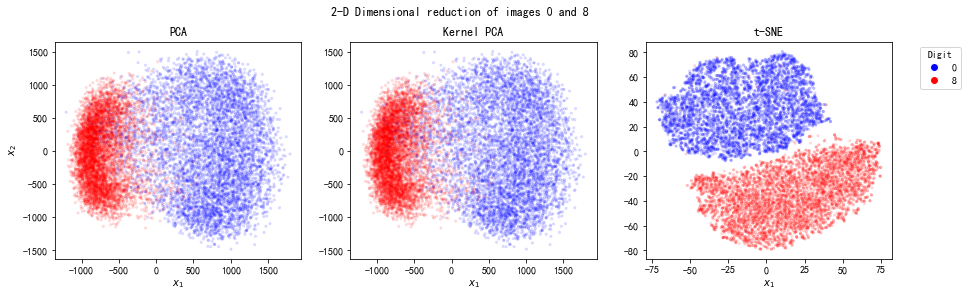

In [ ]:
import numpy as np
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

# data: take transpose and convert to float to work for PCA. shape (p, n), 784 singular values
X = X08.T*1.
mu = np.mean(X, axis=1) # (784,)
X = X-mu[:,None]    # normalize X by substract mean of column from column

# SVD of X
u,s,vt = np.linalg.svd(X, full_matrices=True)  # solve 784 singular values of X

alphahat_pca = PCA(n_components=2).fit_transform(X.T) # (11774, 2) alphahat_pca = u[:,:2].T @ X  (2, 11774)
alphahat_kernelpca = KernelPCA(n_components=2, kernel='linear').fit_transform(X.T)     # (11774, 2)
alphahat_tsne = TSNE(n_components=2).fit_transform(X.T) # (11774, 2)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].scatter(alphahat_pca[:, 0], alphahat_pca[:, 1],c=np.where(y08,'red','blue'), alpha=0.1, s=5)
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].set_title("PCA")

axs[1].scatter(alphahat_kernelpca[:,0], alphahat_kernelpca[:,1],c=np.where(y08,'red','blue'), alpha=0.1,s=5) 
axs[1].set_xlabel(r"$x_1$")
axs[1].set_title("Kernel PCA")

axs[2].scatter(alphahat_tsne[:,0],alphahat_tsne[:,1],c=np.where(y08,'red','blue'),alpha=0.1,s=5)
axs[2].set_xlabel(r"$x_1$")
axs[2].set_title("t-SNE")

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='0',
                          markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='8',
                          markerfacecolor='red', markersize=8)]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1), title='Digit')
plt.suptitle("2-D Dimensional reduction of images 0 and 8", y=1)
plt.show()


In [ ]:
# coordinate of first observ of data
alphahat_pca[:,0]

array([-2054.62782801,  -847.71078357])

## Scree plot

plot all the singular/eigen values in descending order

we can see singular/eigen values drop off rapidly

Most variance captured in first few singular/eigen values

we can trauncate as some point, to set singular values after kth as 0 = noise

Text(0.5, 1.0, 'Scree plot')

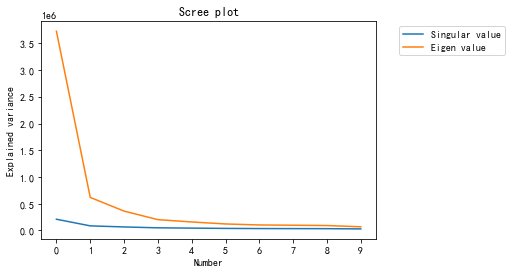

In [ ]:
k = 10
plt.plot(s[:k], label='Singular value') 
plt.plot(s1[:k], label="Eigen value") 
plt.legend(bbox_to_anchor=(1.4, 1))
plt.xlabel("Number")
plt.ylabel("Explained variance")
plt.xticks(np.arange(0, k, step=1))
plt.title("Scree plot")

## rank k reconstruction of data

reconstructted data in rank k space

$$
X_k = U_k \hat \alpha = U_k (U_k^T X)
$$

Text(0.5, 0.9, 'First image')

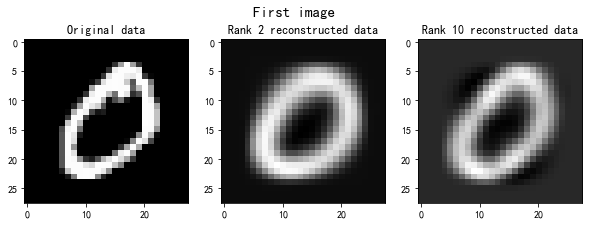

In [ ]:
# rank 2 and rank 10 reconstruction of data
# rank 10 captures more variance of data than rank 2
alphahat = u.T @ X
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(X[:,0].reshape(28,28),cmap='gray')
axs[0].set_title("Original data")
axs[1].imshow((u[:,:2] @ alphahat[:2,0]).reshape(28,28),cmap='gray')
axs[1].set_title("Rank 2 reconstructed data")
axs[2].imshow((u[:,:10] @ alphahat[:10, 0]).reshape(28,28),cmap='gray')
axs[2].set_title("Rank 10 reconstructed data")  
fig.suptitle("First image", y=0.9, fontsize=15)

Text(0.5, 0.9, 'Singular vector of data')

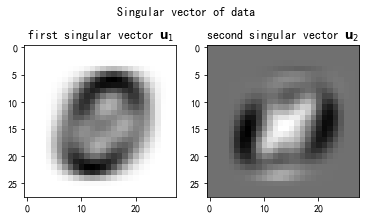

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(u[:,0].reshape(28,28),cmap='gray') # average over all 0 and 8
axs[0].set_title(r"first singular vector $\mathbf{u}_1$")
axs[1].imshow(u[:,1].reshape(28,28),cmap='gray') # white is big, just focus on center piece
axs[1].set_title(r"second singular vector $\mathbf{u}_2$")
fig.suptitle("Singular vector of data", y=0.9)

**reconstruction/low-rank** interpretation of SVD (second interpretation). 

**reconstruction error** can be expressed as

where $A$ is an orthogonal matrix

$$
E = \underset{A \mid A \in \mathbb{R}^{p \times k}}{\min}\sum_{i=1}^n \|A A^T \mathbf{x}_i - \mathbf{x}_i \|_2^2 = \underset{A \mid A \in \mathbb{R}^{p \times k}}{\min}\|A A^T X - X \|_F^2
$$

the solution is $A = U_k$, the first $k$ singular vectors of $U$. 

reconstruction error is sum of squared singular value of $X$ from $k+1$ th to $p$ th

$$
\begin{align}
E 
&= \|U_k U_k^T X - X\|_F^2 \\[1em]
&= \|U_k U_k^T U S V^T - U S V^T\|_F^2 \\[1em]
&= \|U_k U_k^T U S - U S\|_F^2\ \\[1em]
&= \|U S \|_F^2 - \|U_k U_k^T U S\|_F^2 \\[1em]
&= \sum_{i={k+1}}^{p} \sigma_i^2 \\[1em]
\end{align}
$$